# Kenteken OCR
Dit notebook is bedoeld voor het uitlezen van de kentekenplaten. Het notebook is af in de zin dat men kenteken detectie + uitlezing kan uitvoeren. Het uitlezen echter is momenteel vrij inaccuraat. 

In [21]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [22]:
%flake8_on

In [23]:
import numpy as np
from numpy import expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2
from mrcnn.model import mold_image
from PIL import Image, ImageEnhance, ImageFilter
import pytesseract
# Change path to your own tesseract installation.
# Tesseract installation: https://github.com/tesseract-ocr/tesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

13:80: E501 line too long (87 > 79 characters)


# Model Inladen

In [3]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "plate_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [4]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_plate_cfg_0100.h5', by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








# Kenteken Detectie

In [5]:
def predict_once(img, model, cfg):
    """
    :param img: path to the image we want to detect plates on
    :param model: license plate detection model
    :param cfg: configuration for the model
    :type img: string
    :type model: .h5 file
    :type cfg: PredictionConfig
    :return boxes: detected bounding boxes
    :return image: the img
    :type boxes: list
    :type image: image
    """
    # load image and mask
    image = cv2.imread(img)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    # define subplot
    # plot raw pixel data
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Predicted')
    ax = plt.gca()
    # plot each box
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the figure
    plt.show()
    return yhat['rois'], image

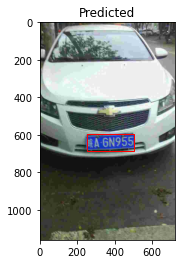

In [11]:
boxes, img = predict_once(r".\Dataset\TrainAndTest\images\00010.jpg",
                          model, cfg)

# Croppen
De gedecteerde kentekenplaat/kentekenplaten worden in dit gedeelte uit de foto gesneden.

In [12]:
def first_crops(img, boxes):
    """
    :param img: image we're cropping
    :param boxes: bounding boxes possibly containing plates
    :type img: image
    :type boxes: list
    :return crops: return made crops
    :type crops: list
    """
    crops = []
    for box in boxes:
        # get coordinates
        y1, x1, y2, x2 = box
        firstCrop = img[y1:y2, x1:x2]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        crops.append(firstCrop)
    return crops

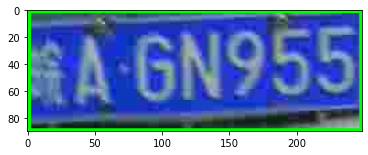

In [13]:
first_c = first_crops(img, boxes)
plt.imshow(cv2.cvtColor(first_c[0], cv2.COLOR_BGR2RGB))

In [14]:
def secondCrop(img):
    """
    :param img: cropped image
    :type img: image
    :return secondCrop:
    :type secondCrop: image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    if(len(areas) != 0):
        max_index = np.argmax(areas)
        cnt = contours[max_index]
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        secondCrop = img[y:y + h, x:x + w]
    else:
        secondCrop = img
    return secondCrop

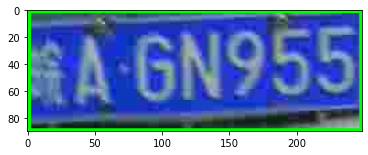

In [15]:
second_crop = secondCrop(first_c[0])
plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))

# Kenteken Uitlezen
In dit gedeelte wordt Tesseract gebruikt voor het uitlezen van de uitgesneden kenteken foto's. Dit gedeelte is nog niet af, omdat Tesseract nog gefinetuned moet worden. 

In [16]:
# Read the number plate
text = pytesseract.image_to_string(second_crop, config='--psm 8')
print("Detected license plate Number is:", text)

Detected license plate Number is: @N-GN95S



In [17]:
plate_crop = Image.fromarray(second_crop)
new_size = tuple(14*x for x in plate_crop.size)
resized_img = plate_crop.resize(new_size, Image.ANTIALIAS)

In [18]:
resized_img = resized_img.filter(ImageFilter.SHARPEN)

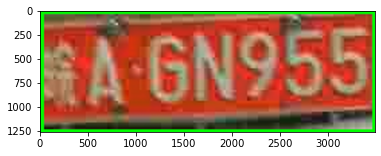

In [19]:
plt.imshow(resized_img)

In [20]:
# Read the number plate
text = pytesseract.image_to_string(resized_img, config='--psm 8')
print("Detected license plate Number is:", text)

Detected license plate Number is: @N-GN95S



# Bronnen
Brownlee, J. (2020, September 1). How to Train an Object Detection Model with Keras. Machine Learning Mastery. https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

Matterport, M. (2018, March 20). matterport/Mask_RCNN. GitHub. https://github.com/matterport/Mask_RCNN

Theophilebuyssens, T. (2020, January 28). License Plate Recognition using OpenCV, YOLO and Keras. Medium. https://medium.com/@theophilebuyssens/license-plate-recognition-using-opencv-yolo-and-keras-f5bfe03afc65